<a href="https://colab.research.google.com/github/brendaFlavia/DeepLearningAssignment/blob/main/LungOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import glob
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, utils, losses, callbacks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, accuracy_score, roc_auc_score

In [ ]:
data_dir = "/content/gdrive/MyDrive/DeepLearning/dataset1"
#test_data_dir = "/content/gdrive/MyDrive/dataset1/known_images"
#validation_dir="/content/gdrive/MyDrive/dataset1/known_images"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
#train and Validation data directory 
data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/Dataset1') 

#test data directory
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
img_width, img_height = 391,488
batch_size = 10

In [ ]:
# Define image data generators
# Train data


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [ ]:
# Test generator
#test_generator = image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 715 files belonging to 2 classes.
Using 143 files for validation.


In [ ]:
#test dataset




In [ ]:
#batch_size=10
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=50
  )


Found 50 files belonging to 1 classes.


In [ ]:
# Load class names for the dataset
class_names = train_ds.class_names
print(class_names)

['normal', 'sick']


In [ ]:
#Virtualize the training dataset

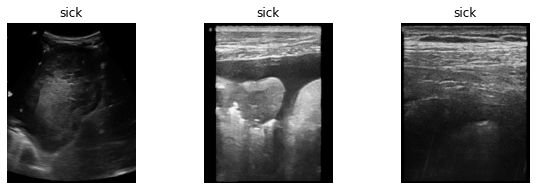

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#print shape the training dataset

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 488, 391, 3)
(10,)


In [ ]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 488, 391, 3)
(10,)


In [ ]:
#print shape of validation dataset

In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 488, 391, 3)
(10,)


In [ ]:
#normalize the dataset

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9852265


In [ ]:
#configure dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#create a model
model = models.Sequential()

In [ ]:
num_classes = num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
#complie the model

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 243, 194, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 120, 96, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 118, 94, 32)      

In [ ]:
#fit the model with training dataset

In [ ]:
result=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
)

Epoch 1/10
143/143 [==============================] - 293s 981ms/step - loss: 0.3162 - accuracy: 0.8497 - val_loss: 0.1539 - val_accuracy: 0.9510
Epoch 2/10
143/143 [==============================] - 140s 978ms/step - loss: 0.1150 - accuracy: 0.9598 - val_loss: 0.1322 - val_accuracy: 0.9510
Epoch 3/10
143/143 [==============================] - 139s 974ms/step - loss: 0.1083 - accuracy: 0.9633 - val_loss: 0.1650 - val_accuracy: 0.9371
Epoch 4/10
143/143 [==============================] - 139s 976ms/step - loss: 0.0613 - accuracy: 0.9755 - val_loss: 0.1696 - val_accuracy: 0.9441
Epoch 5/10
143/143 [==============================] - 139s 973ms/step - loss: 0.0390 - accuracy: 0.9790 - val_loss: 0.1545 - val_accuracy: 0.9510
Epoch 6/10
143/143 [==============================] - 139s 973ms/step - loss: 0.0054 - accuracy: 0.9965 - val_loss: 0.2125 - val_accuracy: 0.9510
Epoch 7/10
143/143 [==============================] - 139s 973ms/step - loss: 0.0022 - accuracy: 0.9983 - val_loss: 0.2182 -

In [ ]:


test_loss, test_acc = model.evaluate(val_ds, verbose=2)



36/36 - 7s - loss: 0.2495 - accuracy: 0.9441 - 7s/epoch - 203ms/step


In [ ]:
#Visualize training results

Text(0.5, 1.0, 'Training and Validation Accuracy')

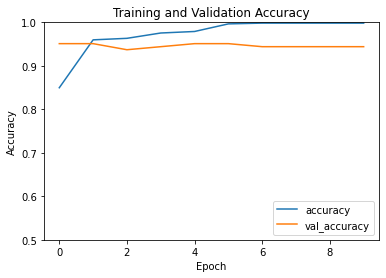

In [ ]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
#print accauracy

In [ ]:
print(test_acc)

0.9440559148788452


Text(0.5, 1.0, 'Training and Validation Loss')

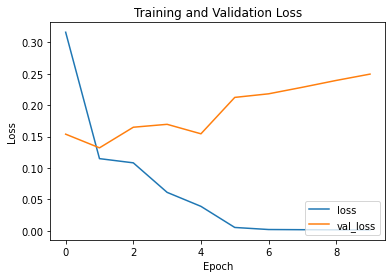

In [ ]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
#Test the model

In [ ]:
#load test data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pathlib
test_data_dir = pathlib.Path('/content/gdrive/My Drive/DeepLearning/unknown_images') 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Predictions:
 [1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0
 1 0 1 1 0 0 1 0 1 1 0 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


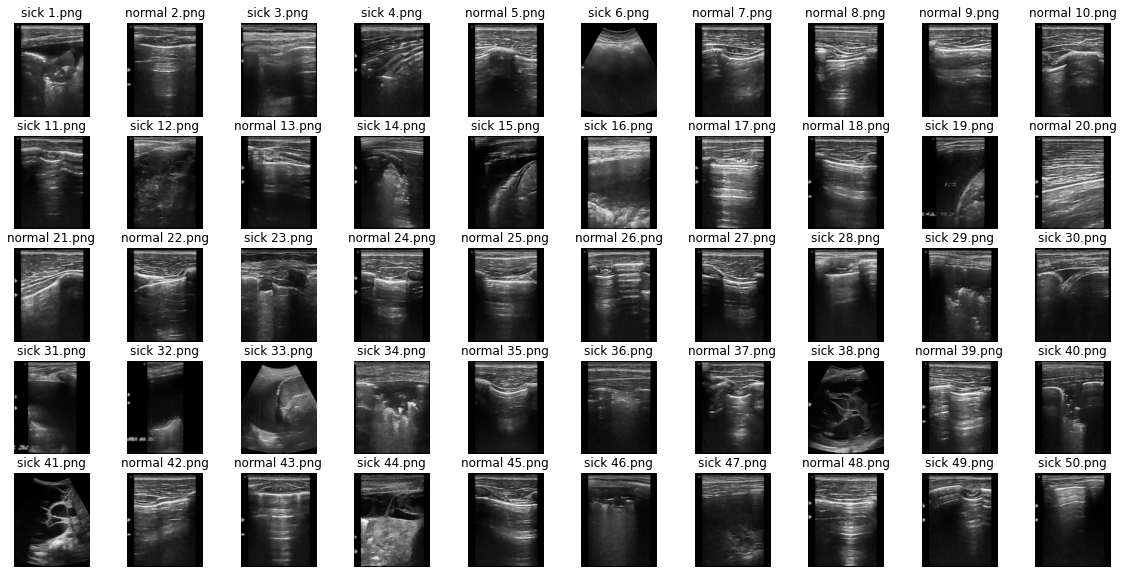

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")

In [ ]:
#Introduce Data Augumentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
#visualize augumented images

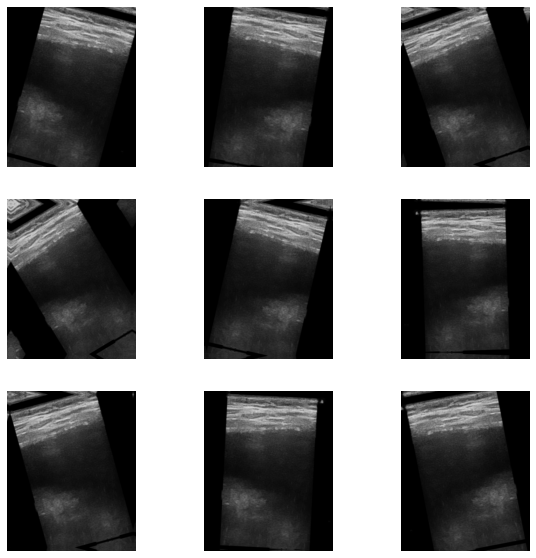

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Build model with data augumentation

In [ ]:

model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 243, 194, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 120, 96, 32)      0         
 g2D)                                                 

In [ ]:
#fit the model

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
58/58 [==============================] - 144s 2s/step - loss: 0.5017 - accuracy: 0.7483 - val_loss: 0.4349 - val_accuracy: 0.8042
Epoch 2/15
58/58 [==============================] - 141s 2s/step - loss: 0.3387 - accuracy: 0.8601 - val_loss: 0.2258 - val_accuracy: 0.9021
Epoch 3/15
58/58 [==============================] - 141s 2s/step - loss: 0.2962 - accuracy: 0.8654 - val_loss: 0.1903 - val_accuracy: 0.9161
Epoch 4/15
58/58 [==============================] - 146s 3s/step - loss: 0.2826 - accuracy: 0.8899 - val_loss: 0.2241 - val_accuracy: 0.9161
Epoch 5/15
58/58 [==============================] - 140s 2s/step - loss: 0.2712 - accuracy: 0.8741 - val_loss: 0.2116 - val_accuracy: 0.9091
Epoch 6/15
58/58 [==============================] - 140s 2s/step - loss: 0.2594 - accuracy: 0.8846 - val_loss: 0.1896 - val_accuracy: 0.9161
Epoch 7/15
58/58 [==============================] - 140s 2s/step - loss: 0.2186 - accuracy: 0.9073 - val_loss: 0.1578 - val_accuracy: 0.9441
Epoch 8/15
58

In [ ]:
#Visualizing results after adding data augumentation

Text(0.5, 1.0, 'Training and Validation Accuracy')

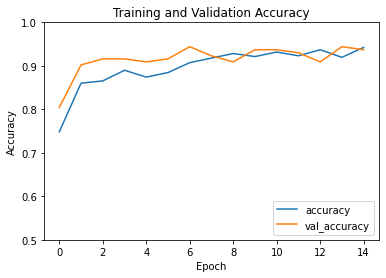

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

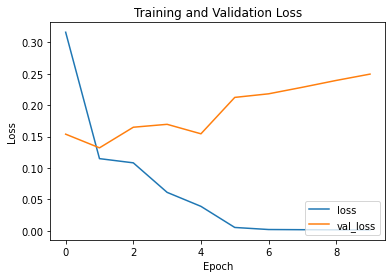

In [ ]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
#using drop out to reduce overfitting the model

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
#complie model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 488, 391, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 488, 391, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 486, 389, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 243, 194, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 241, 192, 32)      9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 120, 96, 32)      0         
 g2D)                                                

In [ ]:
#test model

#fit the model

epochs = 25
history_t = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
58/58 [==============================] - 146s 2s/step - loss: 0.5708 - accuracy: 0.7500 - val_loss: 0.2521 - val_accuracy: 0.8951
Epoch 2/25
58/58 [==============================] - 143s 2s/step - loss: 0.3336 - accuracy: 0.8392 - val_loss: 0.2177 - val_accuracy: 0.9091
Epoch 3/25
58/58 [==============================] - 143s 2s/step - loss: 0.3414 - accuracy: 0.8322 - val_loss: 0.2228 - val_accuracy: 0.8881
Epoch 4/25
58/58 [==============================] - 145s 2s/step - loss: 0.3104 - accuracy: 0.8776 - val_loss: 0.1931 - val_accuracy: 0.9091
Epoch 5/25
58/58 [==============================] - 143s 2s/step - loss: 0.2317 - accuracy: 0.9038 - val_loss: 0.2221 - val_accuracy: 0.9231
Epoch 6/25
58/58 [==============================] - 143s 2s/step - loss: 0.2938 - accuracy: 0.8794 - val_loss: 0.1951 - val_accuracy: 0.9021
Epoch 7/25
58/58 [==============================] - 142s 2s/step - loss: 0.2223 - accuracy: 0.9003 - val_loss: 0.4501 - val_accuracy: 0.8462
Epoch 8/25
58

Predictions:
 [0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 1 1 0 0 0 1 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


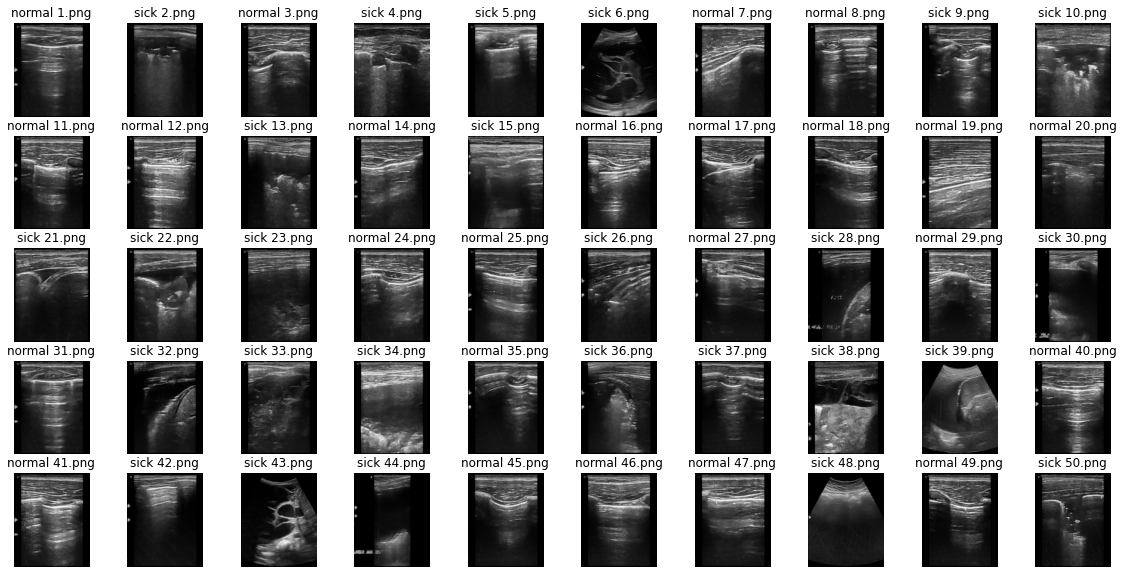

In [146]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]]+ ' '+ str(i+1)+'.png')
  plt.axis("off")